In [17]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [18]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import FCHeadNet
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense, \
    Conv2DTranspose, BatchNormalization, UpSampling2D, LeakyReLU, Dropout, \
    Reshape, Input, Embedding, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from imutils import paths

In [19]:
# initialise the data paths

dbBase = r"C:\Users\mhasa\GDrive\mvcnn"
dbTrainPath = f"{dbBase}//train_mvcnn_color_roi_10class_64px1px_255.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

# get unique labels
labels = list(trainFile["label_names"])
labels = [label.decode() for label in labels]
print(f"Unique Labels: {labels}")

Total no. of classes in dataset: 10
Unique Labels: ['Brackets', 'Bulky', 'Cylindrical', 'Gasket', 'HeadlessScrews', 'Nuts', 'O-Rings', 'Pipes', 'Springs', 'Toothy']


In [20]:
# plot a list of loaded faces
def plot_images(faces, n):
    f, ax = plt.subplots(n, n, figsize=(16,16)) #type: Figure, axes
    faces_iter = iter(faces)
    for row in range(n):
        for col in range(n):
            axis = ax[row][col] #type: axes
            axis.set_yticklabels([])
            axis.set_xticklabels([])
            axis.grid(False)
            next_face = next(faces_iter)
            next_face = np.squeeze(next_face)
            axis.imshow(next_face, cmap='gray_r')
    plt.show()

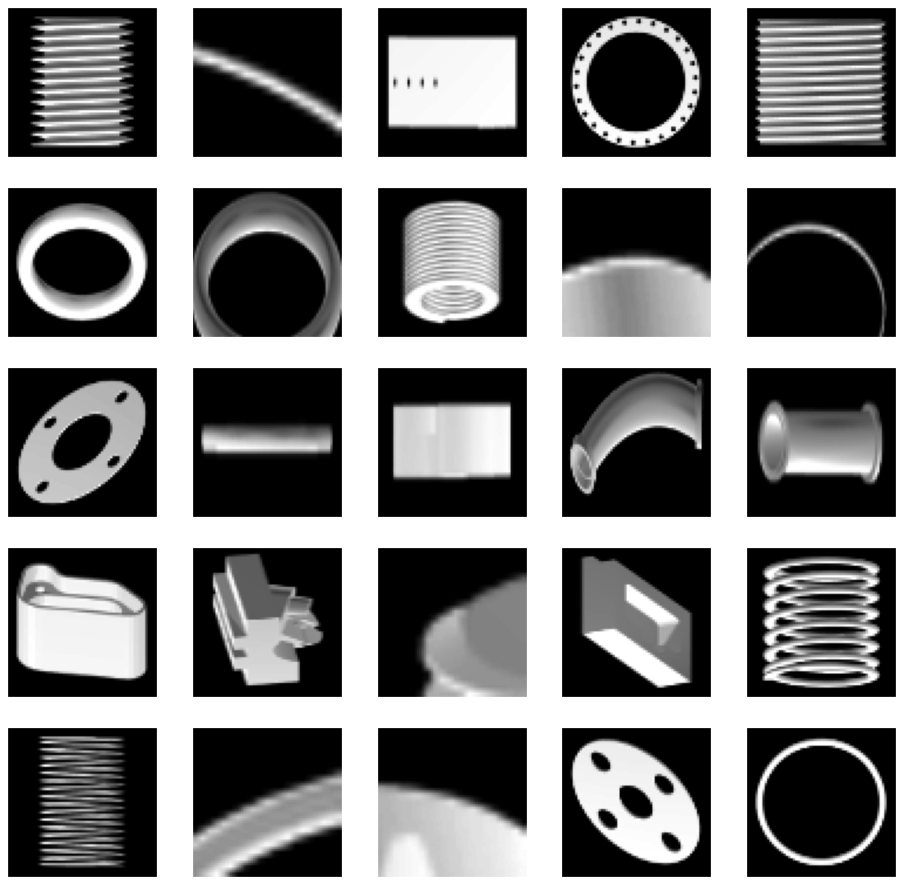

In [21]:
# load the data and plot
(trainx, trainy) = trainFile['images'], trainFile['labels']
plot_images(trainx, 5)

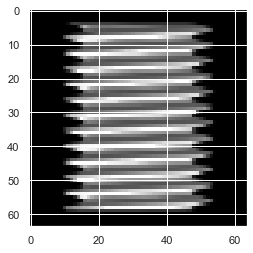

In [22]:
# look at a single image
index = 0
single_image = trainx[index]
single_image = np.squeeze(single_image)
plt.imshow(single_image, cmap='gray_r')

In [23]:
# sanity check of the single image label
single_label = trainy[index]
single_label

4

In [24]:
# define standalone discriminator
def define_discriminator(in_shape=(64,64,1), n_classes=class_num):

    #label input
    in_label = Input(shape=(1,))

    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)

    #scale upto image dimensions with linear activations
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    #reshape to additional channel -> 64x64x1
    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    #image input
    in_image = Input(shape=in_shape)

    # concat the label and channel -> 64x64x2
    merge = Concatenate()([in_image, li])

    #downsample -> 32x32x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample -> 16x16x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # downsample -> 8x8x128
    fe = Conv2D(filters=128,
                kernel_size=(3,3),
                strides=(2,2),
                padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    #flatten feature maps => 8*8*128 = 8192
    fe = Flatten()(fe)

    #Dropout
    fe = Dropout(0.4)(fe)

    #output
    out_layer = Dense(1, activation='sigmoid')(fe)

    # define the model
    model = Model([in_image, in_label], out_layer)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics = ['accuracy'])
    return model

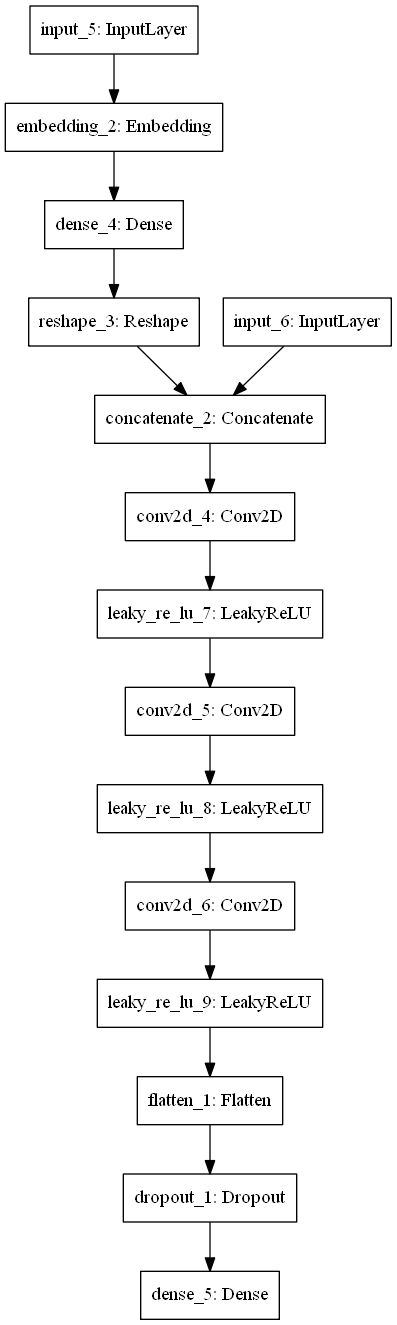

In [25]:
# plot the model
test_d_model = define_discriminator()
plot_model(test_d_model)

In [26]:
# double check dimensions
test_d_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        500         input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1, 4096)      208896      embedding_2[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 64, 64, 1)]  0                                            
____________________________________________________________________________________________

In [27]:
# define the generator
def define_generator(latent_dim, n_classes=class_num):

    # label input
    in_label = Input(shape=(1,))

    # embedding for the categorical input
    li = Embedding(n_classes, 50)(in_label)

    # linear multiplication
    n_nodes = 8*8
    li = Dense(n_nodes)(li)

    # reshape to additional channel
    li = Reshape((8,8,1))(li)

    # image gemnerator input - latent vector
    in_lat = Input(shape=(latent_dim,))

    # foundation for 8x8 image
    n_nodes = 128*8*8
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((8,8,128))(gen)

    # merge the generated image and label input
    merge = Concatenate()([gen, li])

    # upsample to 16x16
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    # upsample to 32x32
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)


    # upsample to 64x64
    gen = Conv2DTranspose(filters=128,
                          kernel_size=(4,4),
                          strides=(2,2),
                          padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)

    #output
    out_layer = Conv2D(filters=1,
                       kernel_size=(7,7),
                       activation='tanh',
                       padding='same')(gen)

    #define the model
    model = Model([in_lat, in_label], out_layer)
    return model

In [28]:
# sanity check
test_g_model = define_generator(100, 5)
#plot_model(test_g_model)

In [29]:
# sanity check dimensions
test_g_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8192)         827392      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        250         input_7[0][0]                    
____________________________________________________________________________________________

In [30]:
# define the combine geenrator and discriminator model
def define_gan(g_model:Model, d_model:Model):

    # make weights of the discrim not trainable
    d_model.trainable = False

    # get noise and label inputs from generator
    gen_noise, gen_label = g_model.input

    # get image output from generator model
    gen_output = g_model.output

    # connect image output and label input from generator as inputs to discrim
    gan_output = d_model([gen_output, gen_label])

    # define gan model
    model = Model([gen_noise, gen_label], gan_output)

    # compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [31]:
# sanity check
test_gan_model = define_gan(test_g_model, test_d_model)
#plot_model(test_gan_model)

In [32]:
test_gan_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 8192)         827392      input_8[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        250         input_7[0][0]                    
____________________________________________________________________________________________

In [33]:
# load real samples
def load_real_samples():
    # load the dataset
    trainx, trainy = trainFile['images'][:], trainFile['labels'][:]

    x = trainx.astype('float32')

    # scale to -1 +1_
    x = (x - 0.5) / 0.5

    return [x, trainy]

def generate_real_samples(dataset, n_samples):

    # split into images and labels
    images, labels = dataset

    # choose random instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    ix = sorted(ix)

    # sleect the random images and labels
    x, labels = images[ix], labels[ix]

    # generate class labels
    y = np.ones((n_samples, 1))

    return [x, labels], y

In [34]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=class_num):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)

    # generate labels
    labels = np.random.randint(0, n_classes, n_samples) # these are fake labels
    return [z_input, labels]


# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):

    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    #predict outputs
    images = generator.predict([z_input, labels_input])

    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [36]:
# train the generator and discriminator
d_real_losses = []
d_fake_losses = []

d_real_accus = []
d_fake_accus = []

gan_losses = []

def train(g_model:Model,
          d_model:Model,
          gan_model:Model,
          dataset:np.ndarray,
          latent_dim,
          n_epochs = 500,
          n_batch=128):

    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # manually enumerate epochs
    for i in range(n_epochs):
        #enumerate batches over the training set
        for j in range(bat_per_epo):

            #get randomly selected real samples
            [xreal, labels_real], y_real = generate_real_samples(dataset, half_batch)

            # update discrim model weights
            dloss1, dacc1 = d_model.train_on_batch([xreal, labels_real], y_real)
            d_real_losses.append(dloss1)
            d_real_accus.append(dacc1)
            

            # generate fake samples
            [xfake, labels], y_fake = generate_fake_samples(g_model,
                                                            latent_dim, half_batch)
            # update discrim model weights
            dloss2, dacc2 = d_model.train_on_batch([xfake, labels], y_fake)
            d_fake_losses.append(dloss2)
            d_fake_accus.append(dacc2)
            

            # prepare points in latent space as generator input
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            #create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))

            # update the generator
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            gan_losses.append(g_loss)

            #summarise loss on this batch
            print(f"{i+1},  {j+1}/{bat_per_epo},  d1={dloss1:0.3f}  "
                  f"d2={dloss2:0.3f} g={g_loss:0.3f}")

    g_model.save(f"{dbBase}//model_gan_10class_64px1px_255.hdf5")

In [ ]:
# size of the latent space
latent_dim = 100

# create the discrim
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load the image data
dataset = load_real_samples()

# train the model
train(g_model=g_model,
      d_model=d_model,
      gan_model=gan_model,
      dataset=dataset,
      latent_dim=latent_dim,
     n_epochs=500)

1,  1/84,  d1=0.675  d2=0.696 g=0.692
1,  2/84,  d1=0.560  d2=0.699 g=0.688
1,  3/84,  d1=0.474  d2=0.708 g=0.679
1,  4/84,  d1=0.356  d2=0.728 g=0.658
1,  5/84,  d1=0.246  d2=0.777 g=0.619
1,  6/84,  d1=0.194  d2=0.869 g=0.565
1,  7/84,  d1=0.147  d2=0.989 g=0.507
1,  8/84,  d1=0.135  d2=1.104 g=0.488
1,  9/84,  d1=0.181  d2=1.115 g=0.515
1,  10/84,  d1=0.260  d2=0.997 g=0.592
1,  11/84,  d1=0.325  d2=0.875 g=0.707
1,  12/84,  d1=0.417  d2=0.713 g=0.839
1,  13/84,  d1=0.426  d2=0.578 g=0.987
1,  14/84,  d1=0.505  d2=0.507 g=1.099
1,  15/84,  d1=0.522  d2=0.441 g=1.200
1,  16/84,  d1=0.573  d2=0.438 g=1.228
1,  17/84,  d1=0.561  d2=0.399 g=1.297
1,  18/84,  d1=0.574  d2=0.405 g=1.336
1,  19/84,  d1=0.457  d2=0.374 g=1.454
1,  20/84,  d1=0.548  d2=0.333 g=1.552
1,  21/84,  d1=0.543  d2=0.319 g=1.577
1,  22/84,  d1=0.463  d2=0.290 g=1.641
1,  23/84,  d1=0.665  d2=0.306 g=1.531
1,  24/84,  d1=0.420  d2=0.287 g=1.592
1,  25/84,  d1=0.563  d2=0.307 g=1.535
1,  26/84,  d1=0.575  d2=0.319 g=1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



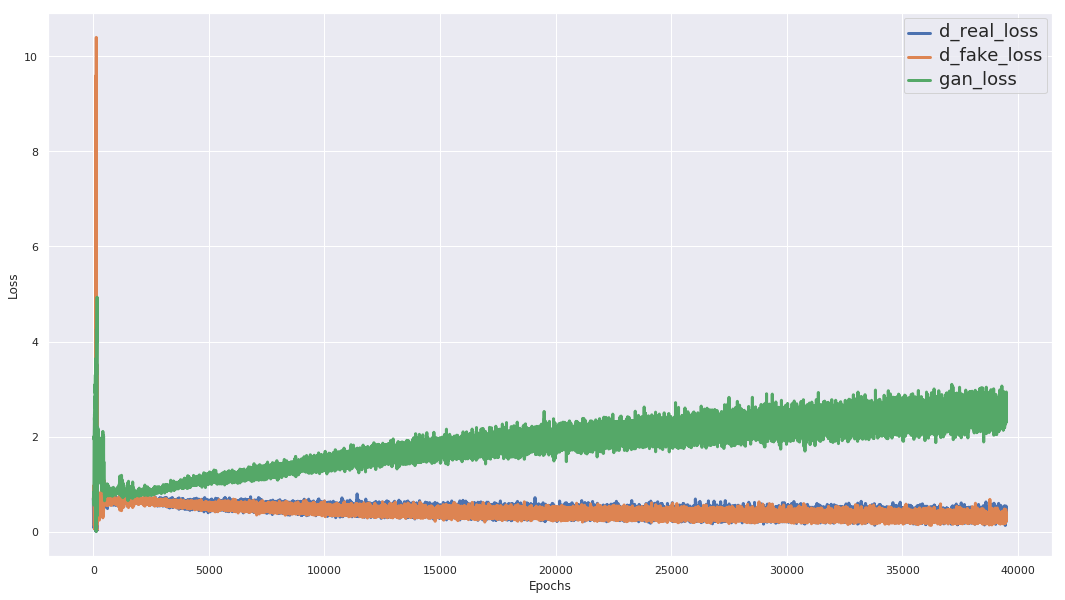

In [211]:
epochs = range(1, len(d_real_losses)+1)
plot_df = pd.DataFrame(data=np.c_[epochs,d_real_losses,d_fake_losses,gan_losses,d_real_accus, d_fake_accus],
                       columns=['epochs','d_real_losses', 'd_fake_losses', 'gan_losses', 'd_real_accus', 'd_fake_accus'])

#%%

sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(18,10))
sns.lineplot(data=plot_df, x='epochs', y='d_real_losses', ax=ax, label='d_real_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='d_fake_losses', ax=ax, label='d_fake_loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='gan_losses', ax=ax, label='gan_loss', linewidth=3)

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text


In [212]:
# create and save a plot of generated images 
from tensorflow.keras.models import load_model
def save_plot(examples): 
    # plot images 
    for i in range(examples.shape[0]): 
        # define subplot 
        plt.subplot(10, 10, 1 + i) 
        
        # turn off axis 
        plt.axis('off') 
        
        # plot raw pixel data 
        plt.imshow(examples[i, :, :, 0], cmap='gray_r') 
    plt.show()

    # load model
model = load_model(f"{dbBase}//model_gan_10class_28px1px_threshinv.hdf5")

In [213]:
# generate images
latent_points, labels = generate_latent_points(100, 100) 

# specify labels 
labels = np.asarray([x for _ in range(10) for x in range(10)]) 
print(labels.shape)
print(labels)

(100,)
[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3
 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]


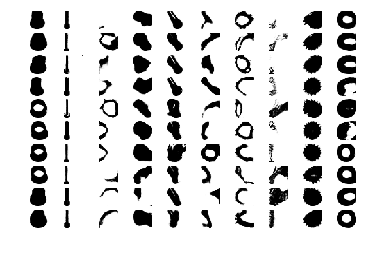

In [215]:
# generate images 
X = model.predict([latent_points, labels]) 

# scale from [-1,1] to [0,1] 
X = (X + 1) / 2.0 

# plot the result
save_plot(X)

In [216]:
classifier_model = load_model(f"{dbBase}//model_10class_28px1px_threshinv.hdf5")

In [217]:
classifier_image = X[5]
classifier_image = np.expand_dims(classifier_image, axis=0)

probs = classifier_model.predict(classifier_image)
label = np.argmax(probs, axis=1)
label[0]

5

In [219]:
part_dict = {
    0: 'Bearings',
    1: 'Bolts',
    2: 'Brackets',
    3: 'Bushing',
    4: 'Collets', 
    5: 'Pipes',
    6: 'PushRings',
    7: 'Springs',
    8: 'Sprockets',
    9: 'Washers'
}
hit_rate_hist = []
runs = 100

for run in range(runs):
    # generate latent points
    latent_points, labels = generate_latent_points(100, 100) 

    # specify conditional labels 
    labels = np.asarray([x for _ in range(10) for x in range(10)]) 
    
    # generate images 
    X = model.predict([latent_points, labels]) 

    # scale from [-1,1] to [0,1] 
    X = (X + 1) / 2.0 

    k = 0
    wrong_items = 0
    for row in range(10):
        for col in range(10):
            classifier_image = X[k]
            classifier_image = np.expand_dims(classifier_image, axis=0)
            probs = classifier_model.predict(classifier_image)
            predicted_label = np.argmax(probs, axis=1)[0]
            predicted_label = part_dict[predicted_label]
            actual_label = part_dict[col]
            print(f"Actual: {actual_label}, Pred: {predicted_label}")
            k+=1

            if actual_label != predicted_label:
                wrong_items += 1
        print("====End of Row====")    
    hit_rate = (k-wrong_items)/k
    hit_rate_hist.append(hit_rate)
    print(f"Wrong Items: {wrong_items}") 
    print(f"Hit Rate: {hit_rate}")

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Springs
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====


Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
A

Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pus

Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Bearings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bracket

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bu

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Springs
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Bearings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual:

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Colle

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 21
Hit Rate: 0.79
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: 

Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Colle

Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 27
Hit Rate: 0.73
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bearings
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing

Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 26
Hit Rate: 0.74
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Col

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actua

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearing

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End 

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Ac

Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 19
Hit Rate: 0.81
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Ac

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actu

Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Wrong Items: 30
Hit Rate: 0.7
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row==

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes


Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 23
Hit Rate: 0.77
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Ac

Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Colle

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Bearings
Actual: Pipes, Pred: Washers
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End o

Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: PushRings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: 

Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Sprockets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Ac

Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 16
Hit Rate: 0.84
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Collets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
A

Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bushing
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushR

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Bearings
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Sprockets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Brackets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Spr

Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Wrong Items: 30
Hit Rate: 0.7
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bushing
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs

Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Sprockets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
A

Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 25
Hit Rate: 0.75
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets


Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bushing
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Act

Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bolts
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====


Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actua

Actual: Brackets, Pred: Collets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Collets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Brackets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pr

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: Springs
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Bearings
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: Pipes
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Sprockets
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Washers
Actual: Bushing, Pred: Bushing
Actua

Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Sprockets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Bearings
Actual: PushRings, Pred: Brackets
Actual: Springs, Pred: PushRings
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Bearings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pre

Actual: PushRings, Pred: Washers
Actual: Springs, Pred: Collets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Pipes
Actual: Collets, Pred: Bushing
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: PushRings
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Springs
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 33
Hit Rate: 0.67
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bearings
Actual: Collets, Pred: Collet

Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Pipes
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Pipes
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Pipes
Actual: Bushing, Pred: Collets
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Brackets
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Actual: Bearings, Pred: Bearings
Actual: Bolts, Pred: Bolts
Actual: Brackets, Pred: Brackets
Actual: Bushing, Pred: Bushing
Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Collets

Actual: Collets, Pred: Collets
Actual: Pipes, Pred: Brackets
Actual: PushRings, Pred: PushRings
Actual: Springs, Pred: Bolts
Actual: Sprockets, Pred: Sprockets
Actual: Washers, Pred: Washers
====End of Row====
Wrong Items: 30
Hit Rate: 0.7


In [220]:
np.mean(hit_rate_hist)

0.7426

In [221]:
np.std(hit_rate_hist)

0.03743314039724694